# Finding solvent-exposed residues 

We want to find residues that are within a certain distance $d$ near solvent molecules. Two approaches could be used

1. simple distance criterion
2. hydrogen-bonded residues

For right now, we will just look at a simple distance criterion.

## Packages

We will use [MDAnalysis](https://mdanalysis.org) and other common Python packages:

In [2]:
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.matplotlib.style.use("ggplot")

import pandas as pd

## Data
For this example, we will use a short trajectory of the enzyme AdK in solvent (water and ions). The trajectory was produced with Gromacs and uses the OPLS-AA forcefield with TIP4P water. It is included as a test file (TPR topology and XTC trajectory)

In [3]:
from MDAnalysisTests.datafiles import TPR, XTC

/Volumes/Data/oliver/Biop/Projects/Methods/MDAnalysis/mdanalysis/testsuite/MDAnalysisTests/__init__.py:118: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Users/oliver/anaconda3/envs/mda_develop/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/oliver/anaconda3/envs/mda_develop/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/oliver/anaconda3/envs/mda_develop/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/oliver/anaconda3/envs/mda_develop/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()


## Analysis: find solvent-exposed residues

We always start with a MDAnalysis `Universe`:

In [4]:
u = mda.Universe(TPR, XTC)

### Distance-based analysis

We want to find residues that have at least one atom within a cutoff $d = 3.5$ Å near a water molecule. (We might have to play with the value of $d$ but 3.5 Å is about the maximum distance for a hydrogen bond and is also less than the thickness of two hydration layers so it seems a reasonable starting point.)

In [33]:
dmax = 3.5  # Ångstrom 

Let's say we are only interested in acidic residues: Asp and Glu, and we only want to consider the heavy atoms (not H):

In [28]:
acidics = u.select_atoms("resname ASP GLU and not name H*")
print(acidics.residues)
acidics.residues

<ResidueGroup [<Residue GLU, 21>, <Residue ASP, 32>, <Residue GLU, 43>, ..., <Residue GLU, 203>, <Residue ASP, 207>, <Residue GLU, 209>]>


<ResidueGroup with 35 residues>

Get the solvent molecules, and specifically, we will just use the central oxygen for the distance calculation:

In [13]:
water = u.select_atoms("resname SOL and name OW")
print(water.n_residues)

11084


#### Basic algorithm 

For each frame in the trajectory we will now calculate the distance between all atoms in the `acidics` group with the water oxygens in the `water` group, using the [distance_array()](https://www.mdanalysis.org/docs/documentation_pages/lib/distances.html#MDAnalysis.lib.distances.distance_array) function:
$$
d_{ij} = ||\mathbf{r}^\text{acidics}_i - \mathbf{r}^\text{water}_j||
$$

Because MD simulations are typically done with periodic boundary conditions, we use the minimum image convention to calculate the shortest distances taking PBC in account — this requires the `box` keyword of `distance_array()`.


In [14]:
from MDAnalysis.lib import distances

In [15]:
dij = distances.distance_array(acidics.positions, water.positions, 
                               box=u.trajectory.ts.dimensions)

Now we need to find distances smaller than $d$ and find those rows $i$ (corresponding to an atom in an acidic residue) in which at least one column $d_{ij} \le d$:

In [16]:
dij.shape

(298, 11084)

In [34]:
exposed_atoms = np.any(dij <= dmax, axis=1)
exposed_atoms.shape

(298,)

For each atom in the acidic residue we now have an `True` entry if they are exposed and `False` if they are not.

We now have to associate the exposed atoms again with the residues. We can use the `exposed_atoms` array as a Boolean index into our original `acidics` atomgroup and just pick out the residues:

In [35]:
exposed_residues = acidics[exposed_atoms].residues

In [36]:
exposed_residues

<ResidueGroup with 35 residues>

It looks as if all acidic residues are exposed.

In [38]:
exposed_residues == acidics.residues

True

#### Trajectory analysis 

Right now we have calculated the distances for the first trajectory frame. We can do the analysis for multiple frames in a trajectory.

First package the analysis into a simple function.

In [40]:
import numpy as np
from MDAnalysis.lib import distances

def get_exposed_residues(atoms, water, dmax=3.5):
    """Find all residues for which atoms are within dmax of water."""
    
    dij = distances.distance_array(atoms.positions, water.positions, 
                                   box=atoms.universe.trajectory.ts.dimensions)
    exposed_atoms = np.any(dij <= dmax, axis=1)
    return atoms[exposed_atoms].residues

Check that the function works:

In [41]:
get_exposed_residues(acidics, water, dmax=3.5)

<ResidueGroup with 35 residues>

In [44]:
get_exposed_residues(acidics, water, dmax=2.5)

<ResidueGroup with 4 residues>

Now we will just count the number of exposed residues as a function of time (and using $d_\text{max}=2.5$ Å to make it more interesting: 

In [65]:
dmax = 2.5

results = np.zeros((u.trajectory.n_frames, 2))   # (time, N_exposed)
for i, ts in enumerate(u.trajectory):
    exposed_residues = get_exposed_residues(acidics, water, dmax=dmax)
    results[i, :] = (ts.time, exposed_residues.n_residues)

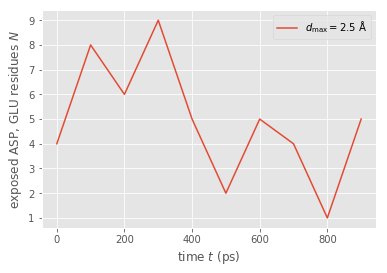

In [67]:
plt.plot(results[:, 0], results[:, 1], 
         label=r"$d_\mathrm{{max}}={0:.1f}$ Å".format(dmax))
plt.xlabel(r"time $t$ (ps)")
plt.ylabel(r"exposed {} residues $N$".format(", ".join(set(acidics.resnames))))
plt.legend(loc="best");